# Exploring Dandiset 001361: A flexible hippocampal population code for experience relative to reward

*This notebook was generated with the assistance of AI. Please verify all code and results before relying on them for research.*

**Dandiset DOI:** [10.48324/dandi.001361/0.250406.0045](https://dandiarchive.org/dandiset/001361/0.250406.0045)

## Overview

Dandiset 001361 contains two-photon imaging data and behavioral measurements from hippocampal CA1 in mice navigating virtual reality environments with changing hidden reward zones. The data, part of the study:

> Sosa, Marielena; Plitt, Mark H.; Giocomo, Lisa M. (2025) A flexible hippocampal population code for experience relative to reward (Version 0.250406.0045) [Data set]. DANDI Archive.

includes neural activity, behavioral events (e.g., licking, reward), and detailed processed outputs (Suite2p) for reanalysis.

## What This Notebook Covers

- An introduction to the dataset and relevant metadata.
- How to access and stream NWB files directly from the DANDI archive using the Dandi API.
- Loading and basic inspection of imaging and behavioral data from a representative session.
- Example code to visualize behavior (virtual position, lick, and reward events) and neural activity (Suite2p ROIs and fluorescence traces).

---

## Required Packages

This notebook assumes the following packages are available:
- dandi
- remfile
- h5py
- pynwb
- numpy
- pandas
- matplotlib

(No installation commands are provided; please ensure the above packages are installed.)

---

## 1. Access Dandiset 001361 Programmatically

Here we access the DANDI Archive via the DandiAPIClient and obtain the download URL for a specific NWB file (`sub-m11_ses-05_behavior+ophys.nwb`). All reading is done via streaming (no file downloads necessary).

In [1]:
# Import required packages
from dandi.dandiapi import DandiAPIClient
import remfile
import h5py
import pynwb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

### Connect to the Dandi Archive and Select a NWB File

In [2]:
# Initialize DANDI API client and specify dandiset/version
dandiset_id = "001361"
version = "0.250406.0045"

client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, version)

# Select an example asset (NWB file) for analysis
nwb_asset = next(dandiset.get_assets_by_glob("sub-m11/sub-m11_ses-05_behavior+ophys.nwb"))
nwb_url = nwb_asset.download_url
print("Streaming NWB file from URL:")
print(nwb_url)

Streaming NWB file from URL:
https://api.dandiarchive.org/api/dandisets/001361/versions/0.250406.0045/assets/a22cc1da-b5e8-4fea-a770-7b83a6e79656/download/


## 2. Stream and Read the NWB File

We stream the file from the archive, then use `h5py` and `pynwb` to open and inspect the data.

In [3]:
# Stream the NWB file using remfile, open with h5py, and use pynwb to read
remote_file = remfile.File(nwb_url)
h5_file = h5py.File(remote_file)
io = pynwb.NWBHDF5IO(file=h5_file)
nwb = io.read()

/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## 3. NWB Session Metadata

In [4]:
# Display session and subject metadata
print("Session description:", nwb.session_description)
print("Session start time:", nwb.session_start_time)
print("Subject ID:", nwb.subject.subject_id)
print("Subject sex:", nwb.subject.sex)
print("Subject age reference:", getattr(nwb.subject, "age__reference", None))
print("Subject species:", nwb.subject.species)
print("Date of birth:", nwb.subject.date_of_birth)
print("Experimenter(s):", nwb.experimenter)

Session description: processed suite2p data
Session start time: 2023-02-25 00:00:00-08:00
Subject ID: m11
Subject sex: M
Subject age reference: birth
Subject species: Mus musculus
Date of birth: 2022-09-20 00:00:00-07:00
Experimenter(s): ('Mari Sosa',)


## 4. Behavioral Data: Overview and Visualization

The behavioral data includes timestamped position in virtual space, speed, lick events, reward delivery, and more. We'll extract and visualize:

- Mouse position on the virtual track
- Lick events (cumulative licks per imaging frame)
- Reward events (times and values)

In [5]:
# Access behavioral time series data
behavior = nwb.processing["behavior"].data_interfaces["BehavioralTimeSeries"].time_series

# Extract position data
position = behavior["position"]
position_data = position.data[:]
position_time = position.timestamps[:]

# Extract lick data
lick = behavior["lick"]
lick_data = lick.data[:]
lick_time = lick.timestamps[:]

# Extract reward data
reward = behavior["Reward"]
reward_data = reward.data[:]
reward_time = reward.timestamps[:]

# Extract reward zone entry binary
reward_zone = behavior["reward_zone"]
reward_zone_data = reward_zone.data[:]
reward_zone_time = reward_zone.timestamps[:]

### Plot: Mouse Position and Behavioral Events

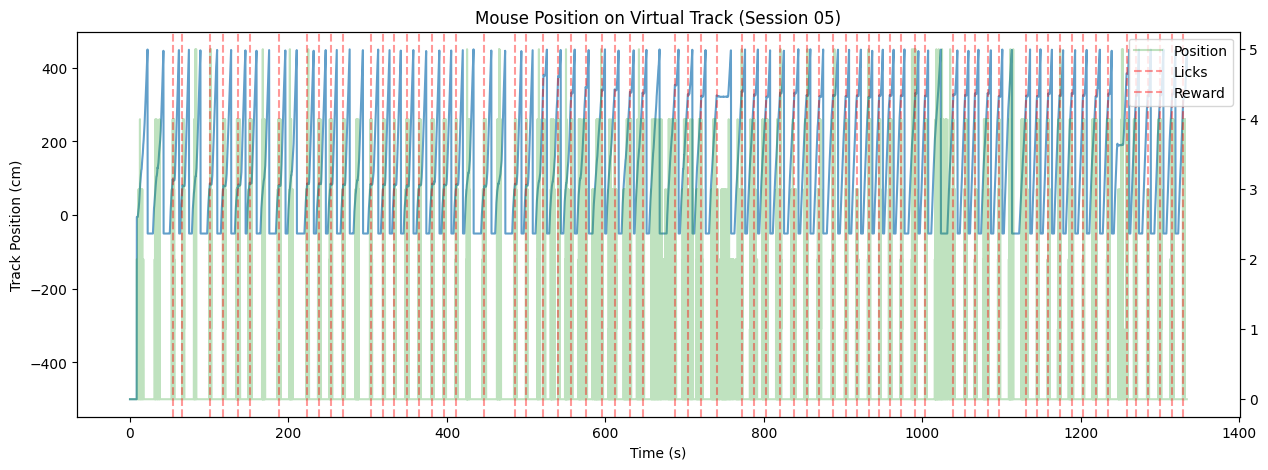

In [6]:
plt.figure(figsize=(15, 5))

plt.plot(position_time, position_data, label='Virtual Position (cm)', color='C0', alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Track Position (cm)')
plt.title('Mouse Position on Virtual Track (Session 05)')
plt.twinx()

# Plot cumulative lick count (scaled for visual reference)
plt.plot(lick_time, lick_data, color='C2', label='Cumulative Licks', alpha=0.3)

# Overlay reward delivery times
for rt in reward_time:
    plt.axvline(rt, color='red', linestyle='--', alpha=0.4, label='Reward' if rt == reward_time[0] else "")

plt.legend(['Position', 'Licks', 'Reward'], loc='upper right')
plt.show()

## 5. Imaging Data: Suite2p ROI Table and Fluorescence Traces

The processed imaging data contains fluorescence (raw, neuropil, deconvolved), pixel masks for ROIs, and suite2p ROI annotations: all available under the `'ophys'` and `'ImageSegmentation'` processing modules.

Here, we extract the Suite2p plane segmentation table and plot traces for a few ROIs.

In [7]:
# Access Suite2p plane segmentation table
# All plane0 ROI tables are equivalent (Fluorescence, Deconvolved, etc)
plane_segmentation = nwb.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['plane0'].rois.table
roi_df = plane_segmentation.to_dataframe()   # n_rois x columns
print("Suite2p ROI Table shape:", roi_df.shape)
roi_df.head()

Suite2p ROI Table shape: (358, 3)


,pixel_mask,iscell,planeIdx
id,,,
0,"[[184, 477, 20.42091], [184, 478, 24.655317], ...","[1.0, 0.9996045543367583]",0
1,"[[220, 548, 17.799917], [220, 549, 21.690094],...","[1.0, 0.9983935935458714]",0
2,"[[198, 485, 19.04672], [198, 486, 17.522465], ...","[1.0, 0.9993062048252185]",0
3,"[[172, 531, 11.773818], [172, 532, 19.495077],...","[1.0, 0.9719317970495572]",0
4,"[[148, 465, 16.043055], [148, 466, 19.642868],...","[1.0, 0.9211749203309639]",0


### Plot: Raw Fluorescence Traces for Example ROIs

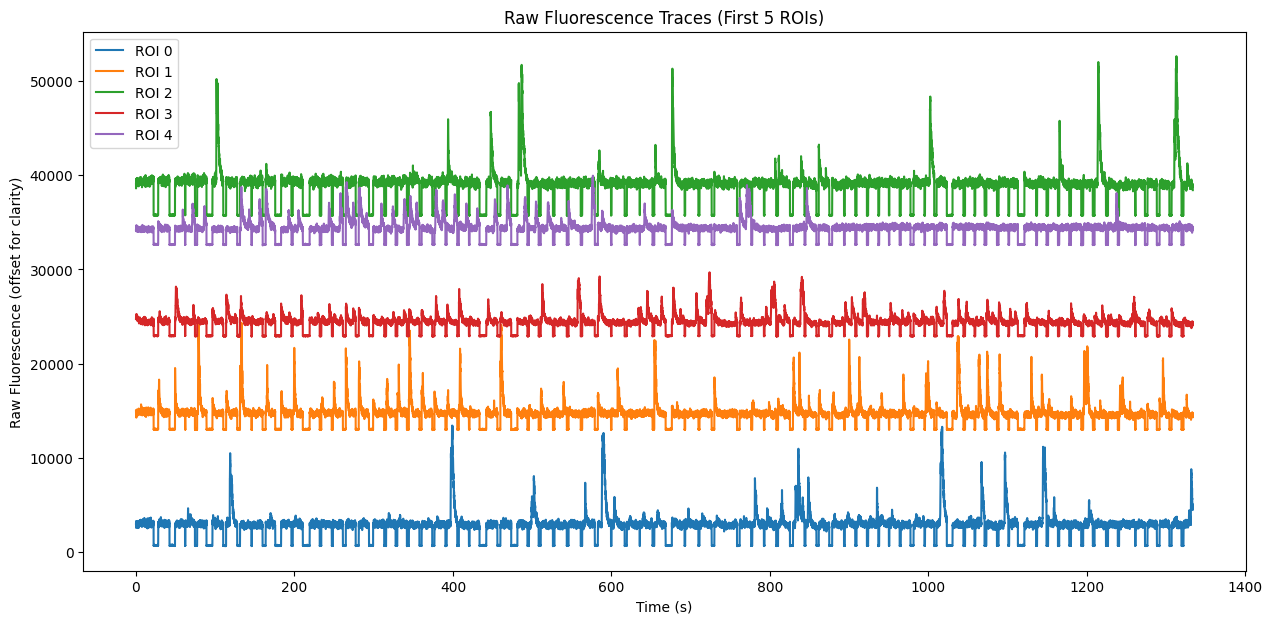

In [8]:
# Access raw fluorescence data: [n_frames, n_rois]
fluo = nwb.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['plane0'].data[:]
sample_roi_indices = np.arange(5)  # Plot first 5 ROIs for illustration

plt.figure(figsize=(15, 7))
for idx in sample_roi_indices:
    plt.plot(np.arange(fluo.shape[0]) / 15.5078125, fluo[:, idx] + idx * np.nanmax(fluo[:, idx]), label=f'ROI {idx}')

plt.xlabel('Time (s)')
plt.ylabel('Raw Fluorescence (offset for clarity)')
plt.title('Raw Fluorescence Traces (First 5 ROIs)')
plt.legend()
plt.show()

## 6. Imaging Plane and Device Metadata

In [9]:
# Show imaging plane and device metadata
iplane = nwb.imaging_planes["ImagingPlane"]
print("Imaging rate:", iplane.imaging_rate)
print("Excitation lambda:", iplane.excitation_lambda)
print("Indicator:", iplane.indicator)
print("Location:", iplane.location)
print("Device:", iplane.device.description)
print("Manufacturer:", iplane.device.manufacturer)
print("Grid spacing (microns):", iplane.grid_spacing[:], iplane.grid_spacing_unit)

Imaging rate: 15.5078125
Excitation lambda: 920.0
Indicator: GCaMP7f
Location: hippocampus, CA1
Device: My two-photon microscope
Manufacturer: Neurolabware
Grid spacing (microns): [2. 2.] microns


## 7. Summary and Next Steps

- **Data access**: Shown how to connect to the DANDI archive and stream NWB data using the DandiClient, remfile, h5py, and pynwb.
- **Inspection**: Summarized session metadata, subject details, behavioral variables, and imaging (Suite2p ROI and traces).
- **Visualization**: Example plots for position, licks, rewards, and neural activity.

### Next Steps for Analysis
- Identification of reward-related and place cell activity using the fluorescence and behavioral event data
- More advanced analysis can be developed using the linked [custom analysis code on GitHub](https://github.com/GiocomoLab/Sosa_et_al_2024)

---

*For further exploration and reanalysis, see the full [Dandiset](https://dandiarchive.org/dandiset/001361/0.250406.0045) and original publication (Nature Neuroscience, Sosa, Plitt, & Giocomo, 2025).*

*Reminder: This notebook was AI-generated and should be reviewed before use in research or publication.*